In [ ]:
'''
Pseudo-Labeling 
Assignment 1: Pseudo-Labeling for Customer Review Sentiment Classification 
Objective: 
Use pseudo-labeling to improve the performance of a sentiment classification model trained 
on a small set of labeled customer reviews, using a much larger set of unlabeled reviews. 
Dataset: 
Amazon product reviews (you can use the public dataset from the Amazon Customer 
Reviews corpus on AWS or Kaggle). 
Steps: 
1. Preprocess the labeled and unlabeled text data (tokenization, lowercasing, etc.). 
2. Train a baseline sentiment classifier (e.g., logistic regression, SVM, or BERT) on the 
labeled dataset. 
3. Use the model to predict labels for the unlabeled reviews (with a confidence 
threshold). 
4. Add high-confidence predictions to the labeled dataset (pseudo-labels). 
5. Retrain the model with the augmented dataset and compare performance. 
Deliverables: 
 Baseline vs. pseudo-labeled model performance (accuracy, F1-score) 
 Code and explanation of pseudo-labeling logic 
 Discussion on confidence threshold and quality of pseudo-labeled data
'''

In [1]:
from datasets import load_dataset

# Load the Amazon Reviews 'All Beauty' subset (requires internet or HF access)
dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_review_All_Beauty", trust_remote_code=True)

# Inspect a sample record (shows text and rating among other fields)
print(dataset["full"][0])


README.md:   0%|          | 0.00/30.3k [00:00<?, ?B/s]

Amazon-Reviews-2023.py:   0%|          | 0.00/39.6k [00:00<?, ?B/s]

All_Beauty.jsonl:   0%|          | 0.00/327M [00:00<?, ?B/s]

Generating full split: 0 examples [00:00, ? examples/s]

{'rating': 5.0, 'title': 'Such a lovely scent but not overpowering.', 'text': "This spray is really nice. It smells really good, goes on really fine, and does the trick. I will say it feels like you need a lot of it though to get the texture I want. I have a lot of hair, medium thickness. I am comparing to other brands with yucky chemicals so I'm gonna stick with this. Try it!", 'images': [], 'asin': 'B00YQ6X8EO', 'parent_asin': 'B00YQ6X8EO', 'user_id': 'AGKHLEW2SOWHNMFQIJGBECAF7INQ', 'timestamp': 1588687728923, 'helpful_vote': 0, 'verified_purchase': True}


In [2]:
# Example: Filter for binary labels and extract text and labels
full_data = dataset["full"]
# Keep only 1-2 (negative) and 4-5 (positive) ratings
binary_data = [x for x in full_data if x['rating'] >=4 or x['rating'] <=2]
texts = [x['text'].lower() for x in binary_data]    # basic lowercasing
labels = [1 if x['rating'] >=4 else 0 for x in binary_data]

# (Optional) Shuffle the data
import random
combined = list(zip(texts, labels))
random.seed(42)
random.shuffle(combined)
texts, labels = zip(*combined)


In [3]:
import re

def clean_text(s):
    # Remove non-letter characters and extra spaces
    s = re.sub(r'http\S+', '', s)          # remove URLs
    s = re.sub(r'[^a-z\s]', '', s)         # remove non-letters
    s = re.sub(r'\s+', ' ', s).strip()     # remove extra whitespace
    return s

texts_clean = [clean_text(t) for t in texts]


In [4]:
num_labels = 200
labeled_texts = texts_clean[:num_labels]
labeled_labels = labels[:num_labels]

unlabeled_texts = texts_clean[num_labels:]


In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
# Fit on labeled texts and transform both labeled and unlabeled
X_labeled = vectorizer.fit_transform(labeled_texts)
X_unlabeled = vectorizer.transform(unlabeled_texts)


In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

# Split labeled data into train/test sets
split = int(0.8 * len(labeled_texts))
X_train, X_test = X_labeled[:split], X_labeled[split:]
y_train, y_test = labeled_labels[:split], labeled_labels[split:]

# Train logistic regression
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Evaluate on the held-out test set
y_pred_initial = clf.predict(X_test)
print("Initial Accuracy:", accuracy_score(y_test, y_pred_initial))
print("Initial F1 score:", f1_score(y_test, y_pred_initial))


Initial Accuracy: 0.8
Initial F1 score: 0.8888888888888888


In [7]:
import numpy as np

# Predict probabilities on unlabeled data
probabilities = clf.predict_proba(X_unlabeled)
max_probs = np.max(probabilities, axis=1)
pseudo_labels = np.argmax(probabilities, axis=1)

# Select high-confidence pseudo-labels
threshold = 0.9
mask_confident = (max_probs >= threshold)
X_pseudo = X_unlabeled[mask_confident]
y_pseudo = pseudo_labels[mask_confident]

print("Selected", X_pseudo.shape[0], "pseudo-labeled samples with prob >=", threshold)


Selected 7 pseudo-labeled samples with prob >= 0.9


In [8]:
from scipy.sparse import vstack

# Augment original labeled training data with pseudo-labeled data
X_augmented = vstack([X_train, X_pseudo])
y_augmented = np.concatenate([y_train, y_pseudo])

# Retrain the model on the augmented data
clf_aug = LogisticRegression(max_iter=1000)
clf_aug.fit(X_augmented, y_augmented)

# Evaluate the new model on the same test set
y_pred_aug = clf_aug.predict(X_test)
print("Augmented Accuracy:", accuracy_score(y_test, y_pred_aug))
print("Augmented F1 score:", f1_score(y_test, y_pred_aug))


Augmented Accuracy: 0.8
Augmented F1 score: 0.8888888888888888


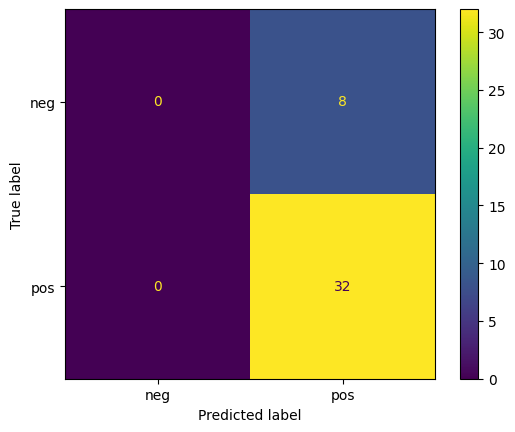

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix for augmented model predictions
cm = confusion_matrix(y_test, y_pred_aug)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['neg','pos'])
disp.plot()
